
# IceVision BBoxes - (New)Fake Data

*This is a mashup of IceVision's "[Custom Parser](https://airctic.com/0.8.0/custom_parser/)" example and their ["Getting Started (Object Detection)"](https://airctic.com/0.8.0/getting_started_object_detection/) notebooks, to analyze SPNet Real dataset, for which I [generated bounding boxes](https://github.com/maskedstudent/SPNet/blob/master/gen_bboxes_csv.py). -- student,  July 1, 2021*

## Installing IceVision and IceData
If on Colab run the following cell, else check the [installation instructions](https://airctic.com/dev/install/)

In [ ]:
# IceVision - IceData - MMDetection - YOLO v5 Installation
#try:
#    !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
#    !chmod +x install_colab.sh && ./install_colab.sh
#except:
#    print("Ignore the error messages and just keep going")

In [ ]:
#all_slow

In [ ]:
# system info
import torch, re 
tv, cv = torch.__version__, torch.version.cuda
tv = re.sub('\+cu.*','',tv)
TORCH_VERSION = 'torch'+tv[0:-1]+'0'
CUDA_VERSION = 'cu'+cv.replace('.','')

print(f"TORCH_VERSION={TORCH_VERSION}; CUDA_VERSION={CUDA_VERSION}")
print(f"CUDA available = {torch.cuda.is_available()}, Device count = {torch.cuda.device_count()}, Current device = {torch.cuda.current_device()}")
print(f"Device name = {torch.cuda.get_device_name()}")

TORCH_VERSION=torch1.8.0; CUDA_VERSION=cu101
CUDA available = True, Device count = 1, Current device = 0
Device name = GeForce RTX 2080 Ti


In [ ]:
# For local Icevision Install of MMD.  cf. https://airctic.com/0.8.1/install/
#!pip install -qq mmcv-full=="1.3.8" -f https://download.openmmlab.com/mmcv/dist/{CUDA_VERSION}/{TORCH_VERSION}/index.html --upgrade
#!pip install mmdet -qq

## Imports
As always, let's import everything from `icevision`. Additionally, we will also need `pandas` (you might need to install it with `pip install pandas`).

In [ ]:
from icevision.all import *
import pandas as pd
from espiownage.core import *

## Download dataset

We're going to be using a small sample of the chess dataset, the full dataset is offered by roboflow [here](https://public.roboflow.com/object-detection/chess-full)

In [ ]:
dataset_name = 'fake'
data_dir = get_data(dataset_name)

## CSV data format

In [ ]:
df = pd.read_csv(data_dir / 'bboxes/annotations.csv')
df.head()

filename  width  height  label  xmin  ymin  xmax  ymax
0  steelpan_0000000.png    512     384      8   135   110   322   287
1  steelpan_0000000.png    512     384      4   399     4   462   103
2  steelpan_0000000.png    512     384      2    20   132    79   211
3  steelpan_0000000.png    512     384      4   353   175   504   254
4  steelpan_0000000.png    512     384      6    75    34   162   105

At first glance, we can make the following assumptions:  

  * Multiple rows with the **same** filename, width, height  
  * A **label** for each row
  * A **bbox** [xmin, ymin, xmax, ymax] for each row  
  
Once we know what our data provides we can create our custom `Parser`.  

In [ ]:
set(np.array(df['label']).flatten())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [ ]:
df['label'] /= 2
df['label'] = df['label'].apply(int) 
print(set(np.array(df['label']).flatten()))
df['label'] = "_"+df['label'].apply(str)+"_"

{0, 1, 2, 3, 4, 5}


In [ ]:
# Let's just make them all the same object:
df['label'] = 'AN'  # antinode
df.head()

filename  width  height label  xmin  ymin  xmax  ymax
0  steelpan_0000000.png    512     384    AN   135   110   322   287
1  steelpan_0000000.png    512     384    AN   399     4   462   103
2  steelpan_0000000.png    512     384    AN    20   132    79   211
3  steelpan_0000000.png    512     384    AN   353   175   504   254
4  steelpan_0000000.png    512     384    AN    75    34   162   105

## Create the Parser

In [ ]:
template_record = ObjectDetectionRecord()

Now use the method `generate_template` that will print out all the necessary steps we have to implement.

In [ ]:
Parser.generate_template(template_record)

class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
    def __iter__(self) -> Any:
    def __len__(self) -> int:
    def record_id(self, o: Any) -> Hashable:
    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
        record.set_filepath(<Union[str, Path]>)
        record.set_img_size(<ImgSize>)
        record.detection.set_class_map(<ClassMap>)
        record.detection.add_labels(<Sequence[Hashable]>)
        record.detection.add_bboxes(<Sequence[BBox]>)


We can copy the template and use it as our starting point. Let's go over each of the methods we have to define:

- `__init__`: What happens here is completely up to you, normally we have to pass some reference to our data, `data_dir` in our case.

- `__iter__`: This tells our parser how to iterate over our data, each item returned here will be passed to `parse_fields` as `o`. In our case we call `df.itertuples` to iterate over all `df` rows.

- `__len__`: How many items will be iterating over.

- `imageid`: Should return a `Hashable` (`int`, `str`, etc). In our case we want all the dataset items that have the same `filename` to be unified in the same record.

- `parse_fields`: Here is where the attributes of the record are collected, the template will suggest what methods we need to call on the record and what parameters it expects. The parameter `o` it receives is the item returned by `__iter__`.

In [ ]:
class BBoxParser(Parser):
    def __init__(self, template_record, data_dir):
        super().__init__(template_record=template_record)
        
        self.data_dir = data_dir
        self.df = pd.read_csv(data_dir / "bboxes/annotations.csv")
        self.df['label'] = 'AN'  # make them all the same object
        self.class_map = ClassMap(list(self.df['label'].unique()))
        
    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o
        
    def __len__(self) -> int:
        return len(self.df)
        
    def record_id(self, o) -> Hashable:
        return o.filename
        
    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(self.data_dir / 'images' / o.filename)
            record.set_img_size(ImgSize(width=o.width, height=o.height))
            record.detection.set_class_map(self.class_map)
        
        record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
        record.detection.add_labels([o.label])

Let's randomly split the data and parser with `Parser.parse`:

In [ ]:
parser = BBoxParser(template_record, data_dir)

In [ ]:
train_records, valid_records = parser.parse()

  0%|          | 0/6923 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/2000 [00:00<?, ?it/s]

Let's take a look at one record:

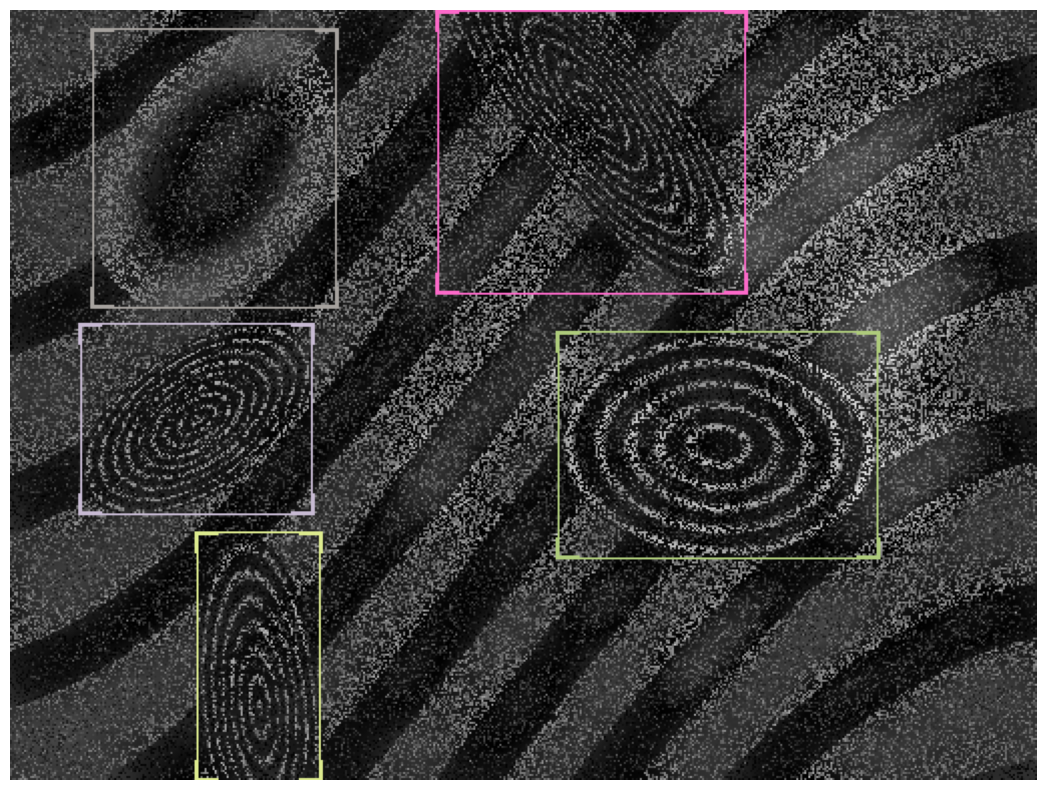

In [ ]:
show_record(train_records[5], display_label=False, figsize=(14, 10))

In [ ]:
train_records[0]

BaseRecord

common: 
	- Filepath: /home/student/.espiownage/data/espiownage-fake/images/steelpan_0000732.png
	- Img: None
	- Image size ImgSize(width=512, height=384)
	- Record ID: steelpan_0000732.png
detection: 
	- Class Map: <ClassMap: {'background': 0, 'AN': 1}>
	- Labels: [1, 1, 1]
	- BBoxes: [<BBox (xmin:211, ymin:212, xmax:336, ymax:331)>, <BBox (xmin:227, ymin:0, xmax:500, ymax:148)>, <BBox (xmin:56, ymin:99, xmax:197, ymax:236)>]

## Moving On...
*Following the Getting Started "refrigerator" notebook...*

In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384  
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

### this next cell generates an error. ignore it and move on

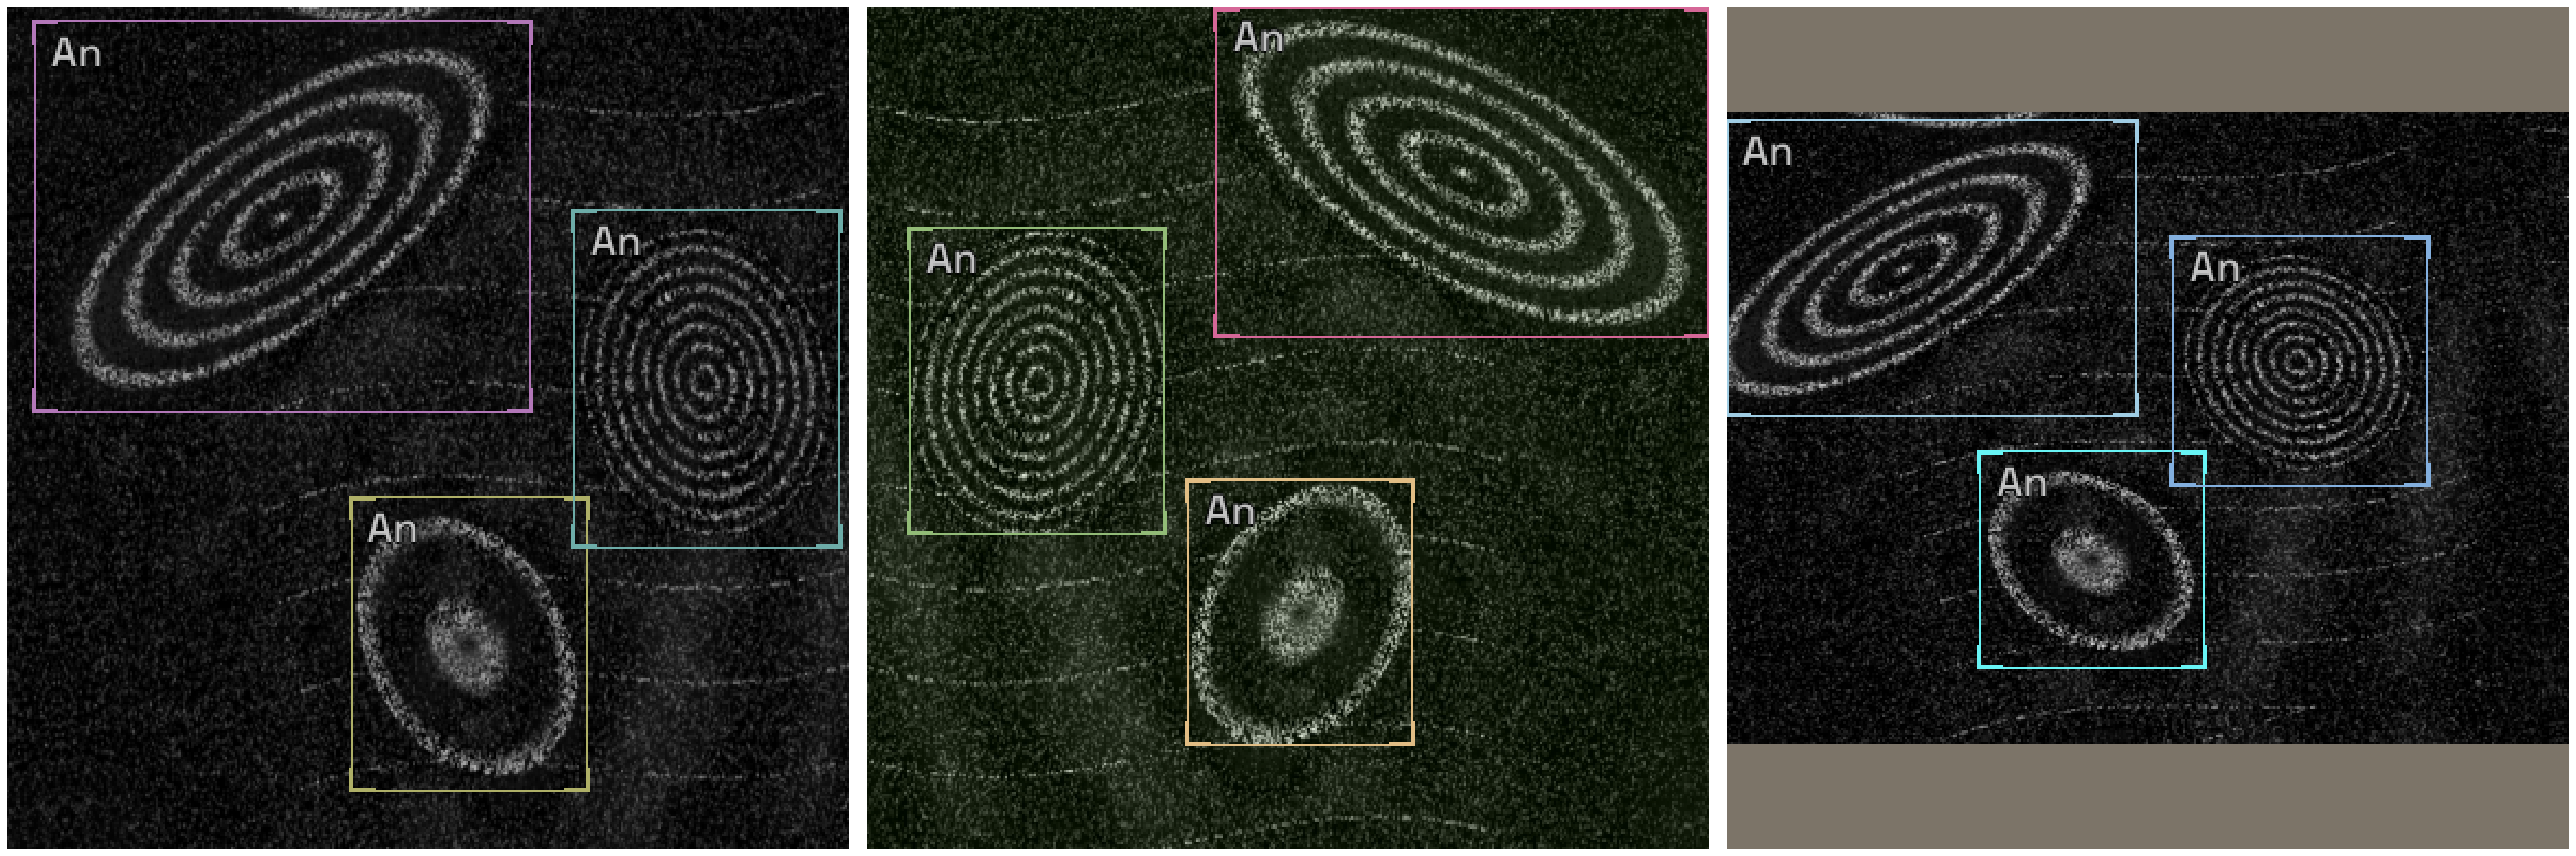

In [ ]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

In [ ]:
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x(pretrained=True)

In [ ]:
# Just change the value of selection to try another model

selection = 1


extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.torchvision.retinanet' from '/home/student/envs/icevision/lib/python3.6/site-packages/icevision/models/torchvision/retinanet/__init__.py'>,
 {})

In [ ]:
# Instantiate the mdoel
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/student/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

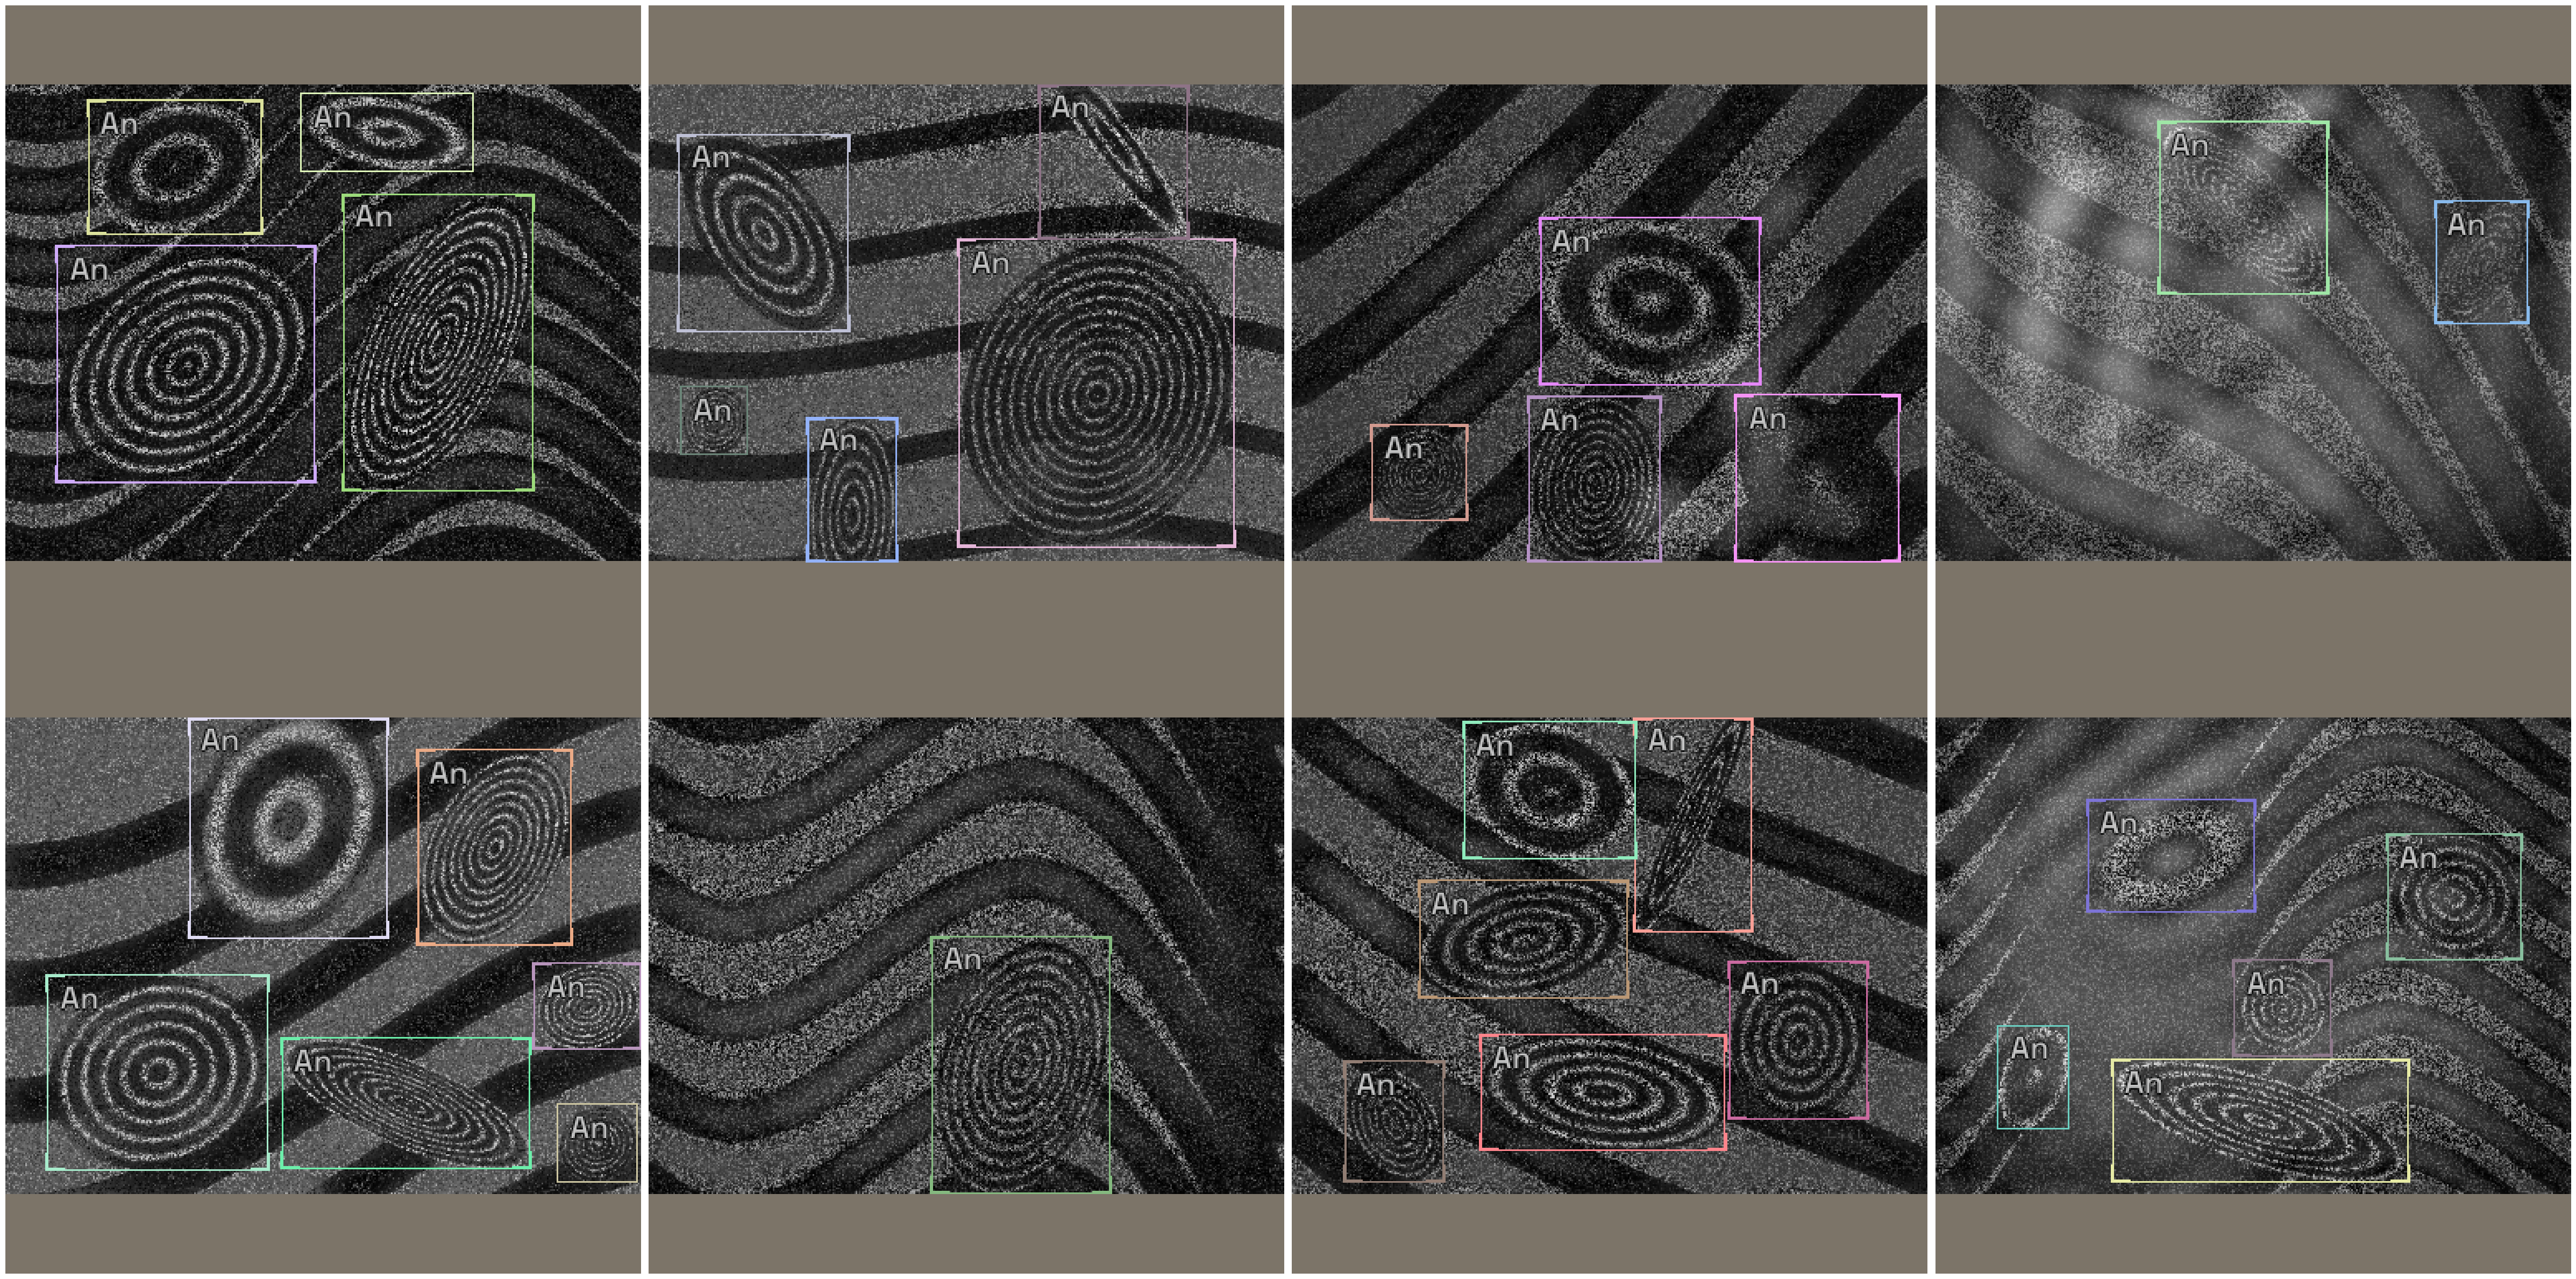

In [ ]:
# show batch - target data
model_type.show_batch(first(valid_dl), ncols=4)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [ ]:
# use the fastai bindings
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=7.945936522446573e-05, lr_steep=9.127484372584149e-05)

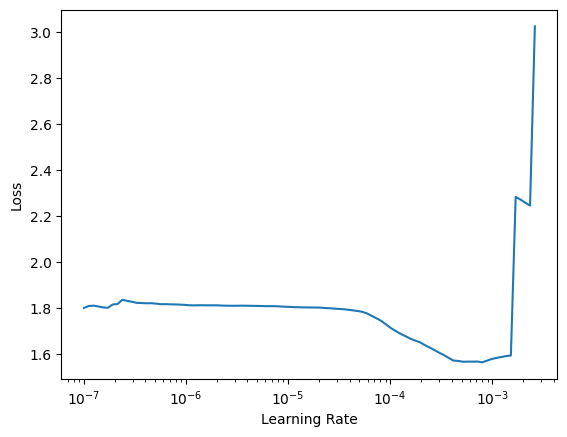

In [ ]:
learn.lr_find(end_lr=5e-3)

# For Sparse-RCNN, use lower `end_lr`
# learn.lr_find(end_lr=0.005)

In [ ]:
kfold = False
epochs = 11 if kfold else 30   # go faster for kfold; 10 is good enough ;-)
freeze_epochs=2
print(f"Training for {epochs} epochs, starting with {freeze_epochs} frozen epochs...")
learn.fine_tune(epochs, 1e-4, freeze_epochs=2)

Training for 30 epochs, starting with 2 frozen epochs...


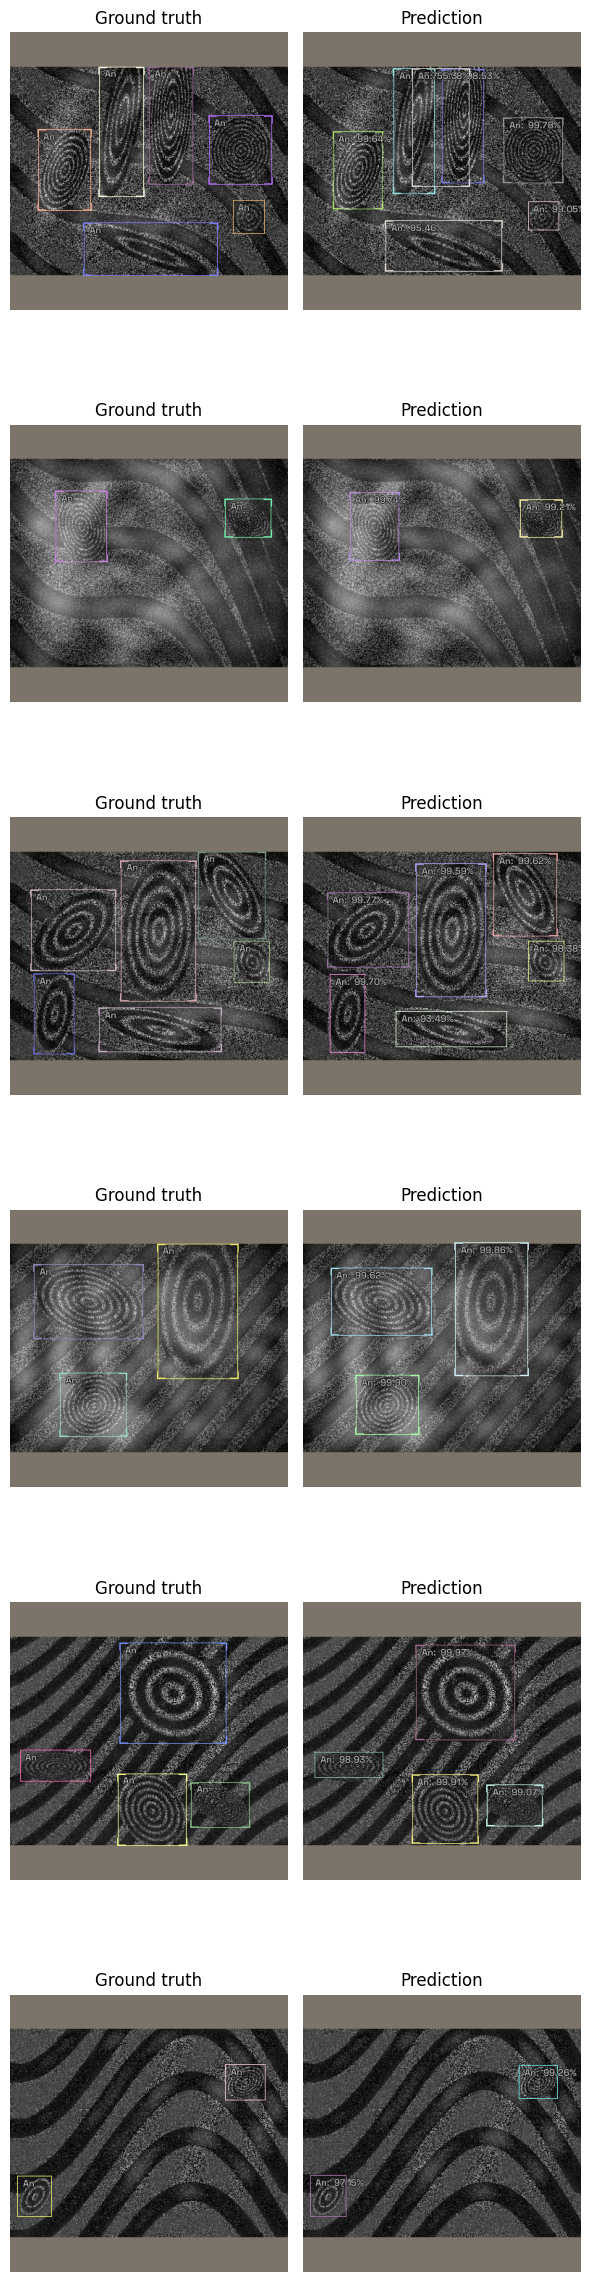

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

In [ ]:
# save the model if you really want to
if False:
    checkpoint_path = f'espi-retinanet-checkpoint-fake.pth'
    save_icevision_checkpoint(model, 
                        model_name='mmdet.retinanet', 
                        backbone_name='resnet50_fpn_1x',
                        classes =  parser.class_map.get_classes(), 
                        img_size=384, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1'})

## Inference

Inference on this model would proceed the same as with the Real dataset. 
But these were all fake, so the necessity or utility of doing so is not evident at this time.

> Note that you'd want to restart and load from a checkpoint as you'll likely get a CUDA OOM error.